# Tuning Random Forests Lab

### Introduction

We have now moved through the main hyperparameters to tune our random forests.  We have seen hyperparameters particular to random forests such as:
* altering the number of trees and 
* the number of features selected.

We have also learned of a hyperparameter in trees, which is:
* altering the depth of a tree

We can adjust the max depth of our trees in our random forest with the same `min_samples_leaf` or `max_depth` argument. Each of these hyperparameters adjust the bias variance tradeoff, and as we move through this lab, we'll review how they play a part.  Also use this lab to review how the hyperparameters can be used to allow our random forests to acheive the twin goals of making each tree:
1. As varied from the other trees as possible
2. As unbiased from the underlying trend as possible

### Loading our data

For this lab, let's work with the diabetes dataset.

Begin by loading the diabetes dataset from sklearn.  Assign `X` to our feature variables and `y` to the target variable.

In [6]:
from sklearn.datasets import load_diabetes

dataset = load_diabetes()
X = dataset['data']
y = dataset['target']

In [7]:
X.shape
# (442, 10)

(442, 10)

In [8]:
y.shape
# (442,)

(442,)

Next, let's split our data into training, test and validation sets.

Perform this by:
1. Splitting the data into training and test sets
2. Splitting the training set into training and validation sets

* Use the `random_state=1` and `test_size=0.2` for both splits.

In [1]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = None, None, None, None

X_train, X_val, y_train, y_val = None, None, None, None

In [63]:
X_train[:1]
# array([[-0.07453279,  0.05068012, -0.00943939,  0.01498661, -0.03734373,
#         -0.02166853, -0.01394774, -0.00259226, -0.03324879,  0.01134862]])

array([[ 0.0562386 ,  0.05068012,  0.00996123,  0.04941532, -0.00432087,
        -0.01227407, -0.04340085,  0.03430886,  0.06078775,  0.03205916]])

In [64]:
X_val[:1]
# array([[ 0.01991321,  0.05068012,  0.01427248,  0.0631868 ,  0.01494247,
#         0.02029337, -0.04708248,  0.03430886,  0.04666077,  0.09004865]])

array([[-0.02730979, -0.04464164,  0.06492964, -0.00222774, -0.02496016,
        -0.01728445,  0.02286863, -0.03949338, -0.0611766 , -0.0632093 ]])

In [65]:
X_test[:1]

#array([[ 0.04170844, -0.04464164, -0.03207344, -0.06190417,  0.07961226,
#         0.05098192,  0.05600338, -0.00997249,  0.04506617, -0.05906719]])

array([[ 0.04170844, -0.04464164, -0.03207344, -0.06190417,  0.07961226,
         0.05098192,  0.05600338, -0.00997249,  0.04506617, -0.05906719]])

In [66]:
X_train.shape

(216, 10)

In [67]:
X_test.shape

(133, 10)

In [68]:
X_val.shape

(93, 10)

### 1. Sampling the Features

Let's first work with the feature sampling parameter.  Feature sampling can make each individual tree less accurate as each tree has fewer parameters to split on.  However, it increases the variance of our trees.  

Below, create four random forest regressors, each with 15 estimators and with a different parameter for feature sampling:  half, square root, and $log_2$ and None.  Use the `feature_sampling_scores` variable to store a list where each element of the list is the value of the parameter along with the related score (see answer below.)

Reference the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) as needed.  Use the parameter `random_state=1` in each random forest regressor.  

In [2]:
feature_sampling_scores = []

In [3]:
feature_sampling_scores

# remember to set random_state=1 in the RandomForestRegressor

# [(0.5, 0.4475590559478998),
#  ('sqrt', 0.4928566781545344),
#  ('log2', 0.4928566781545344),
#  (None, 0.43123659150584004)]

[]

We can see from above that using `sqrt` and `log2` perform the best.

### 2. Number of Trees

Next let's work with the number of trees, or estimators for our random forest.  To save time, instead of creating many different random forest regressors, let's create with fifty estimators, and then see what adding an additional estimator increases the performance of the random forest.

In general, we expect additional estimators to increase our score, but we also expect the benefit of additional estimators to plateau.  So we can build our model more quickly, by limiting the number of estimators.  

Ok, let's do it.

First, train a `RandomForestRegressor` with fifty estimators, and with `random_state=1`.  Also, set `max_features='log2'`.  Store the regressor in a variable called `rfr_n_trees`.

In [4]:

rfr_n_trees = None

In [74]:
rfr_n_trees.score(X_val, y_val)
# 0.5078430350572063

0.5078430350572063

In [75]:
import numpy as np
tree_predictions = np.vstack([estimator.predict(X_val) for estimator in rfr_n_trees.estimators_])

We use `vstack` to create a different row of predictions for each estimator.

In [76]:
tree_predictions.shape

(50, 93)

As we can see, we now have a matrix where each row is dedicated to a separate estimator, and each column is a separate prediction.  Our first row is the predictions for the first estimator.

Next, we'll provide the code that calculates our mean for each additional estimator.

In [77]:
import numpy as np
from sklearn.metrics import r2_score
r2_scores = [r2_score(y_val, np.mean(tree_predictions[:i + 1], axis = 0)) for i in range(0, len(rfr_n_trees.estimators_)) ]

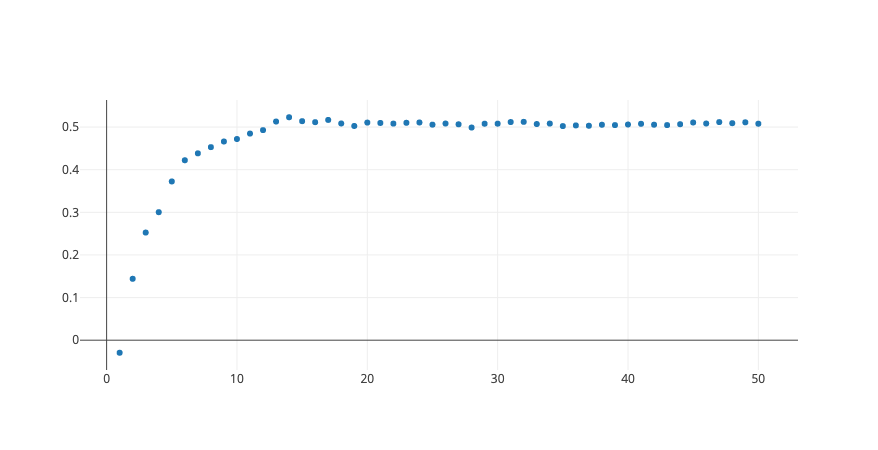

In [78]:
from graph import trace_values, plot
x_vals = list(range(1, len(rfr_n_trees.estimators_) + 1))
trace = trace_values(x_vals, r2_scores)
plot([trace])

As we can see, our `RandomForestRegressor` adding additional trees does not hurt our model, but we know that it takes more time to train a random forest with more estimators.  So we limit the number of estimators to 14, as that is where our performance peaks.

### 3. Number of leaves

Finally, we can control for the complexity of each individual tree.  Remember that as we increase the depth of our tree, our tree becomes more complex, but more likely to overfit as it makes a separate prediction for each individual sample.  As we reduce the number of levels of our tree, our tree becomes less complex such that it may not find the underlying signal in the data and thus can suffer from bias.

Let's try different numbers for `min_sample_leaf`, going from 2 to 50.  Each element in `scores` should be a list with the min_sample_leaf number, and the respective score. 

In [5]:
min_samples = None

scores = []

In [7]:
import numpy as np
wrapped_scores = np.array(scores)

In [8]:
wrapped_scores[:5]

# array([[2.        , 0.45027667],
#        [3.        , 0.43419099],
#        [4.        , 0.43326227],
#        [5.        , 0.42223421],
#        [6.        , 0.42800166]])

array([], dtype=float64)

In [83]:
trace_1 = trace_values(wrapped_scores[:, 0], wrapped_scores[:, 1])

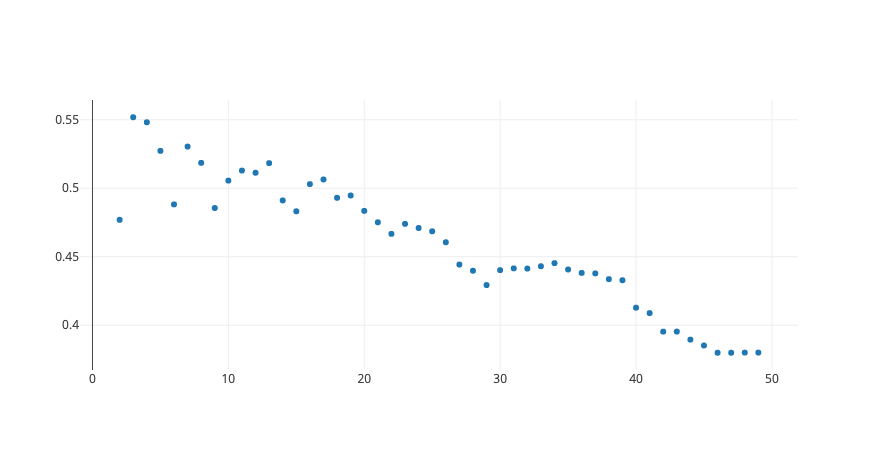

In [84]:
plot([trace_1])

Note that there is a lot of variation, which is due to a small validation set.

In [85]:
X_val.shape

(93, 10)

Still, there appears to be a steady downward trend once we move past a `min_leaf_sample` of three.  So let's choose 3 for our final model.

### Our evaluation

Now that we have tuned each of the hyperparameters, it is time to retrain on our training and validation sets, and then evaluate on our test set.

In [9]:
# combined_X = np.vstack((X_train, X_val))

In [10]:
# combined_y = np.concatenate((y_train, y_val))

Fit a new random forest by training on our combined_X, and evaluating on the test set.  Use the hyperparameters we found above, along with `random_state = 1`.

In [11]:
# 0.31486443277672993

Ah the perils of overfitting.  Here we see a score of around .31 for our overall score.  Now this is below what we wind up with originally.  So we of course, be tempted to change our hyperparameters at this point.  Of course, this wouldn't be improving our model.  After all, our test set is just a random subset of the data as well.  So we would simply be fitting to this randomness.  Here, we'll mark our accuracy at .31.

### Resources

[Random Forest Top to Bottom](https://www.gormanalysis.com/blog/random-forest-from-top-to-bottom/)